Extracted files: ['new_train_sample.csv', 'GUIDE_Test.csv']


<ipython-input-31-b94d339776d2>:43: DtypeWarning: Columns (10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  test_data = pd.read_csv(csv_test_path)
<ipython-input-31-b94d339776d2>:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop_duplicates(inplace=True)
<ipython-input-31-b94d339776d2>:90: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation i

Data Preprocessing Completed
Data Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4758418 entries, 0 to 4758417
Data columns (total 16 columns):
 #   Column         Dtype
---  ------         -----
 0   OrgId          int64
 1   IncidentId     int64
 2   AlertId        int64
 3   AlertTitle     int64
 4   Category       int64
 5   IncidentGrade  int64
 6   EntityType     int64
 7   EvidenceRole   int64
 8   IpAddress      int64
 9   Url            int64
 10  ApplicationId  int64
 11  City           int64
 12  Day            int32
 13  Year           int32
 14  Hour           int32
 15  Time           int64
dtypes: int32(3), int64(13)
memory usage: 526.4 MB
None

Basic Statistics:
               OrgId    IncidentId       AlertId    AlertTitle      Category  \
count  4.758418e+06  4.758418e+06  4.758418e+06  4.758418e+06  4.758418e+06   
mean   1.815396e+02  7.066577e+04  4.062607e+05  2.945133e+03  8.878046e+00   
std    3.868571e+02  1.208436e+05  4.590474e+05  1.145625e+04  3.

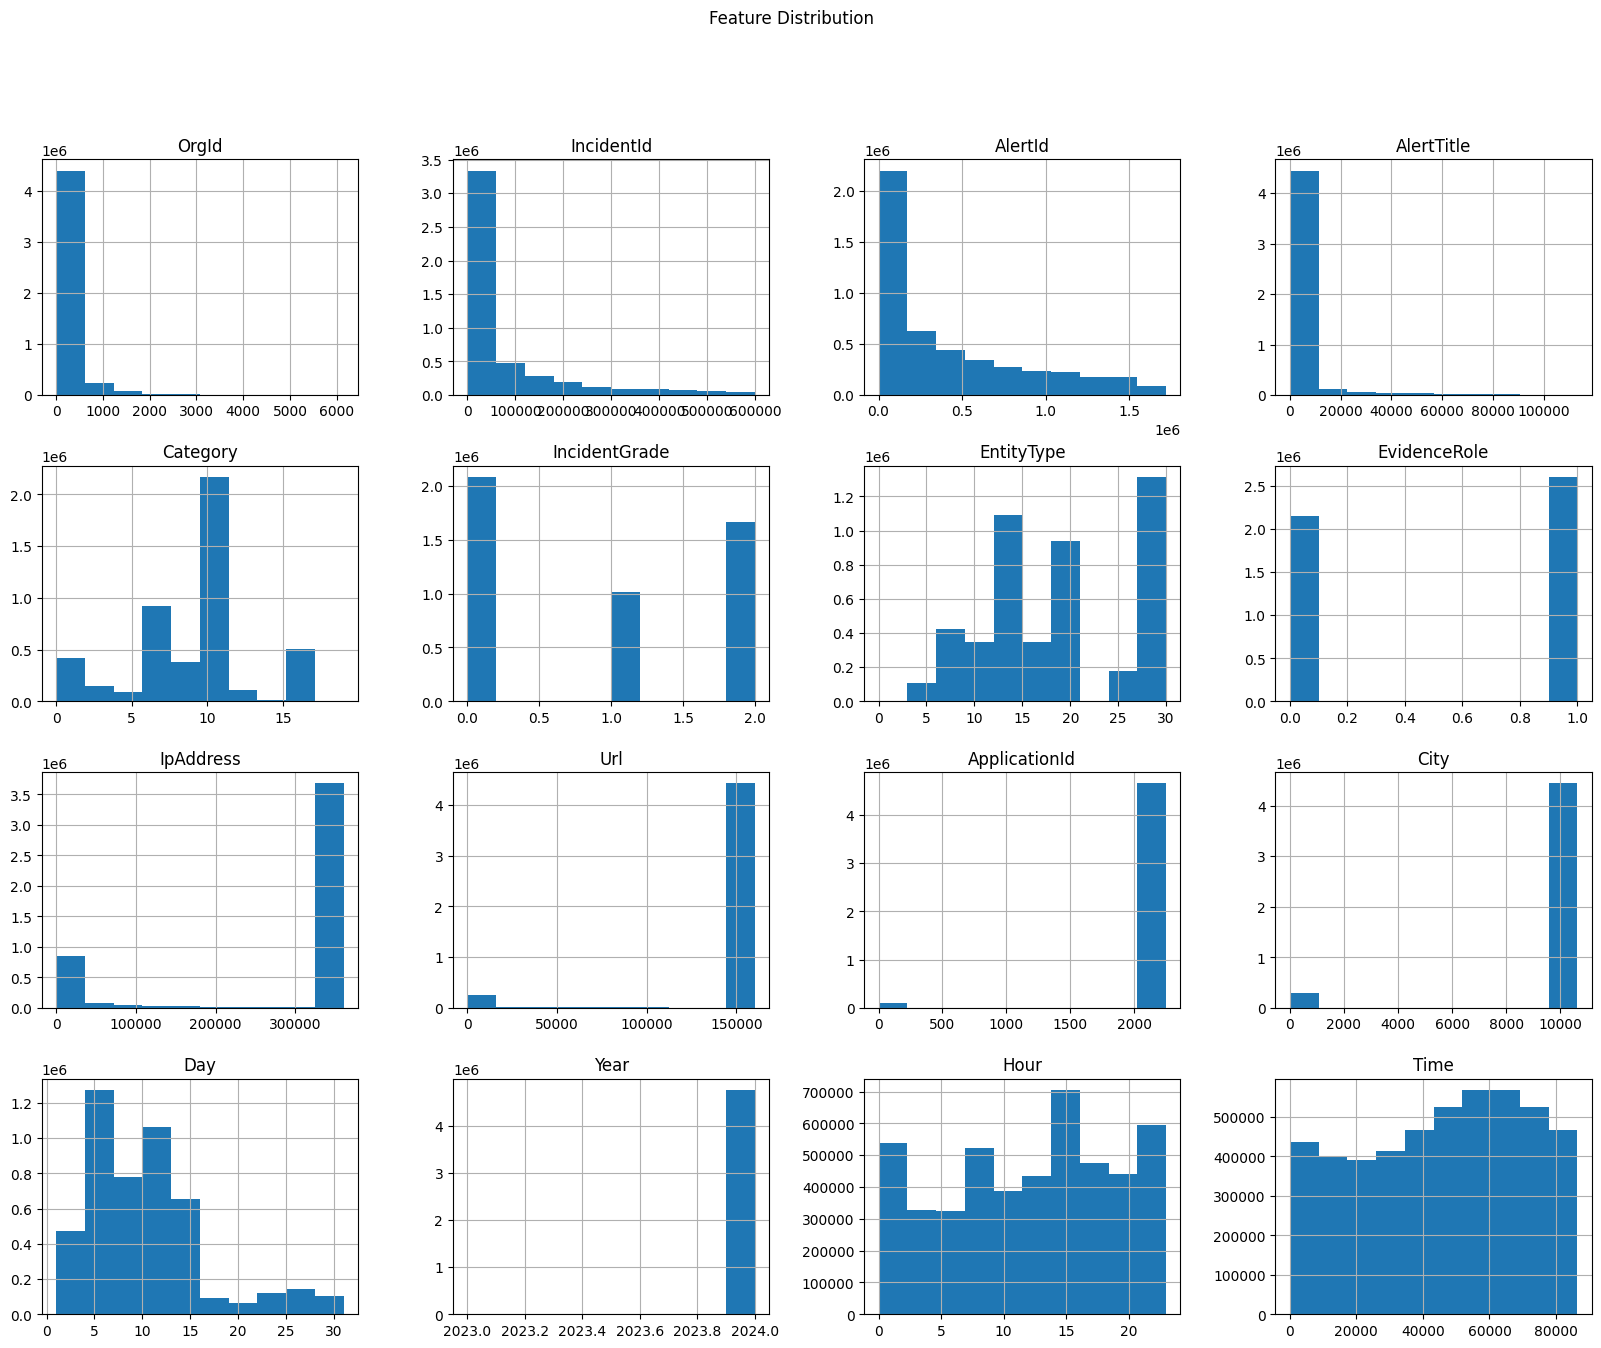

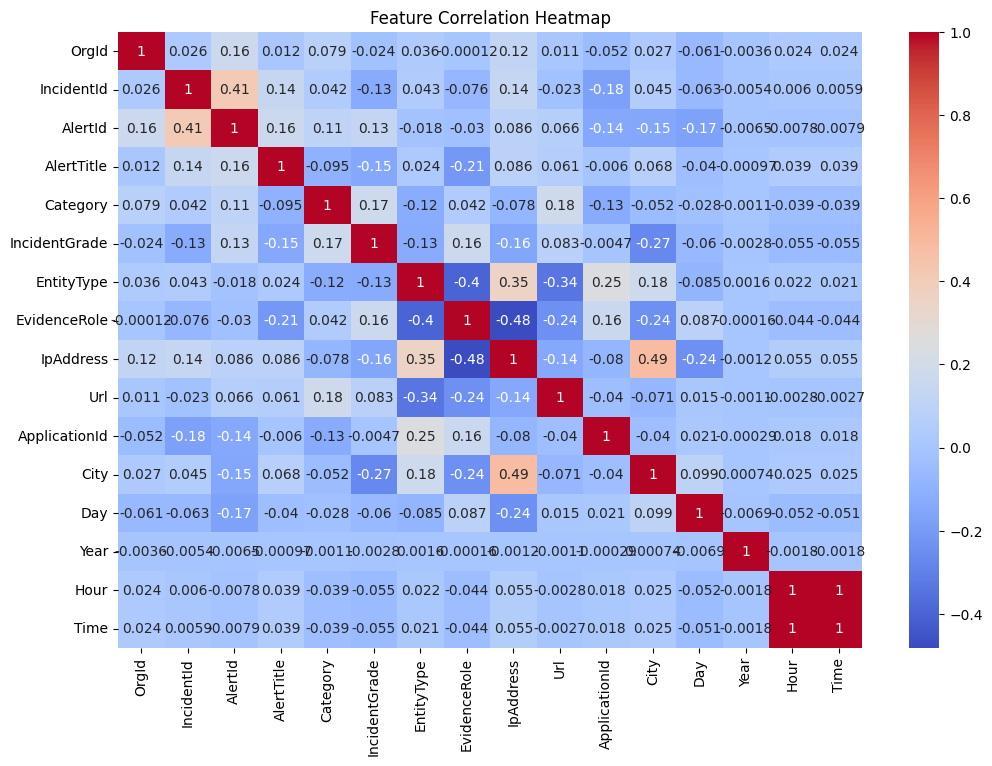

In [31]:
import os
import pandas as pd
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import hstack, csr_matrix
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV,RandomizedSearchCV
from sklearn.metrics import precision_score,f1_score,recall_score,classification_report,accuracy_score
import joblib
from tqdm import tqdm

zip_path_train = "/content/drive/MyDrive/new_train_sample.zip"
extract_path = "/content/drive/MyDrive/extracted_files"

zip_path_test = "/content/drive/MyDrive/GUIDE_Test.csv.zip"
extract_path = "/content/drive/MyDrive/extracted_files"
# Extract the ZIP files
with zipfile.ZipFile(zip_path_train, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
# Extract the ZIP files
with zipfile.ZipFile(zip_path_test, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# List extracted files to confirm
extracted_files = os.listdir(extract_path)
print("Extracted files:", extracted_files)

# Load the CSV files
csv_train_path = os.path.join(extract_path, 'new_train_sample.csv')
csv_test_path = os.path.join(extract_path, 'GUIDE_Test.csv')

train_data = pd.read_csv(csv_train_path)
test_data = pd.read_csv(csv_test_path)

def exploratory_data_analysis(data):
    # Display basic statistics and data types
    print("Data Info:\n")
    print(data.info())
    print("\nBasic Statistics:\n", data.describe())

    # Check for missing values
    print("\nMissing Values:\n", data.isnull().sum())

    # Histograms for numerical features
    data.hist(figsize=(20, 15))
    plt.suptitle('Feature Distribution')
    plt.show()

    # Correlation heatmap for numerical features only
    numeric_data = data.select_dtypes(include=['number'])

    if not numeric_data.empty:
        plt.figure(figsize=(12, 8))
        sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm')
        plt.title('Feature Correlation Heatmap')
        plt.show()
    else:
        print("No numerical data available for correlation heatmap.")


# Data Preprocessing
cat_columns = ['Category', 'EntityType', 'EvidenceRole', 'SuspicionLevel', 'LastVerdict',
               'ResourceType', 'Roles', 'AntispamDirection', 'ThreatFamily']
numerical_columns = ['DeviceId', 'Sha256', 'IpAddress', 'Url', 'AccountSid', 'AccountUpn', 'AccountObjectId',
                     'AccountName', 'DeviceName', 'NetworkMessageId', 'EmailClusterId', 'RegistryKey',
                     'RegistryValueName', 'RegistryValueData', 'ApplicationId', 'ApplicationName',
                     'OAuthApplicationId', 'FileName', 'FolderPath', 'ResourceIdName', 'OSFamily',
                     'OSVersion', 'CountryCode', 'State', 'City']

# Preprocess data
def data_preprocessing(data):
    # Removing columns with more than 50% missing values
    threshold = len(data) * 0.5
    data = data.dropna(thresh=threshold, axis=1)

    # Dropping duplicate rows
    data.drop_duplicates(inplace=True)

    # Filling missing values in 'IncidentGrade' with the mode
    data["IncidentGrade"].fillna(data["IncidentGrade"].mode()[0], inplace=True)

    # Converting 'Timestamp' to datetime and extracting useful components
    data['Timestamp'] = pd.to_datetime(data['Timestamp'])
    data["Day"] = data["Timestamp"].dt.day
    data["Month"] = data["Timestamp"].dt.month
    data["Year"] = data["Timestamp"].dt.year
    data["Hour"] = data["Timestamp"].dt.hour
    data["Time"] = data["Timestamp"].dt.time

    # Dropping 'Timestamp' as it is no longer needed
    data.drop("Timestamp", axis=1, inplace=True)
    # Filling missing values in remaining important columns
    data['State'].fillna(data['State'].mode()[0], inplace=True)
    data['CountryCode'].fillna(data['CountryCode'].mode()[0], inplace=True)
    data['City'].fillna(data['City'].mode()[0], inplace=True)
    # Dropping highly correlated or unnecessary columns
    data.drop(["Month", "DeviceName", "DeviceId", "ResourceIdName", "Unnamed: 0",
               "OAuthApplicationId", "NetworkMessageId", "CountryCode", "Sha256",
               "ApplicationName", "RegistryValueName", "AccountSid", "AccountObjectId",
               "FolderPath", "AccountUpn", "RegistryKey", "RegistryValueData",
               "DetectorId", "Id", "OSFamily", "OSVersion", 'State', 'FileName', 'AccountName'],
              axis=1, inplace=True, errors='ignore')


    # Encoding categorical columns with LabelEncoder
    Categorical_coltr = ['Category', 'IncidentGrade', 'EntityType', 'EvidenceRole', 'Time']
    encoders = {}
    for col in Categorical_coltr:
        le = LabelEncoder()
        data[col] = le.fit_transform(data[col])
        encoders[col] = le

    # Saving the processed data to CSV
    #data.to_csv('/content/datatrain_process.csv', index=False)

    print("Data Preprocessing Completed")
    return data

train_data = data_preprocessing(train_data)
exploratory_data_analysis(train_data)




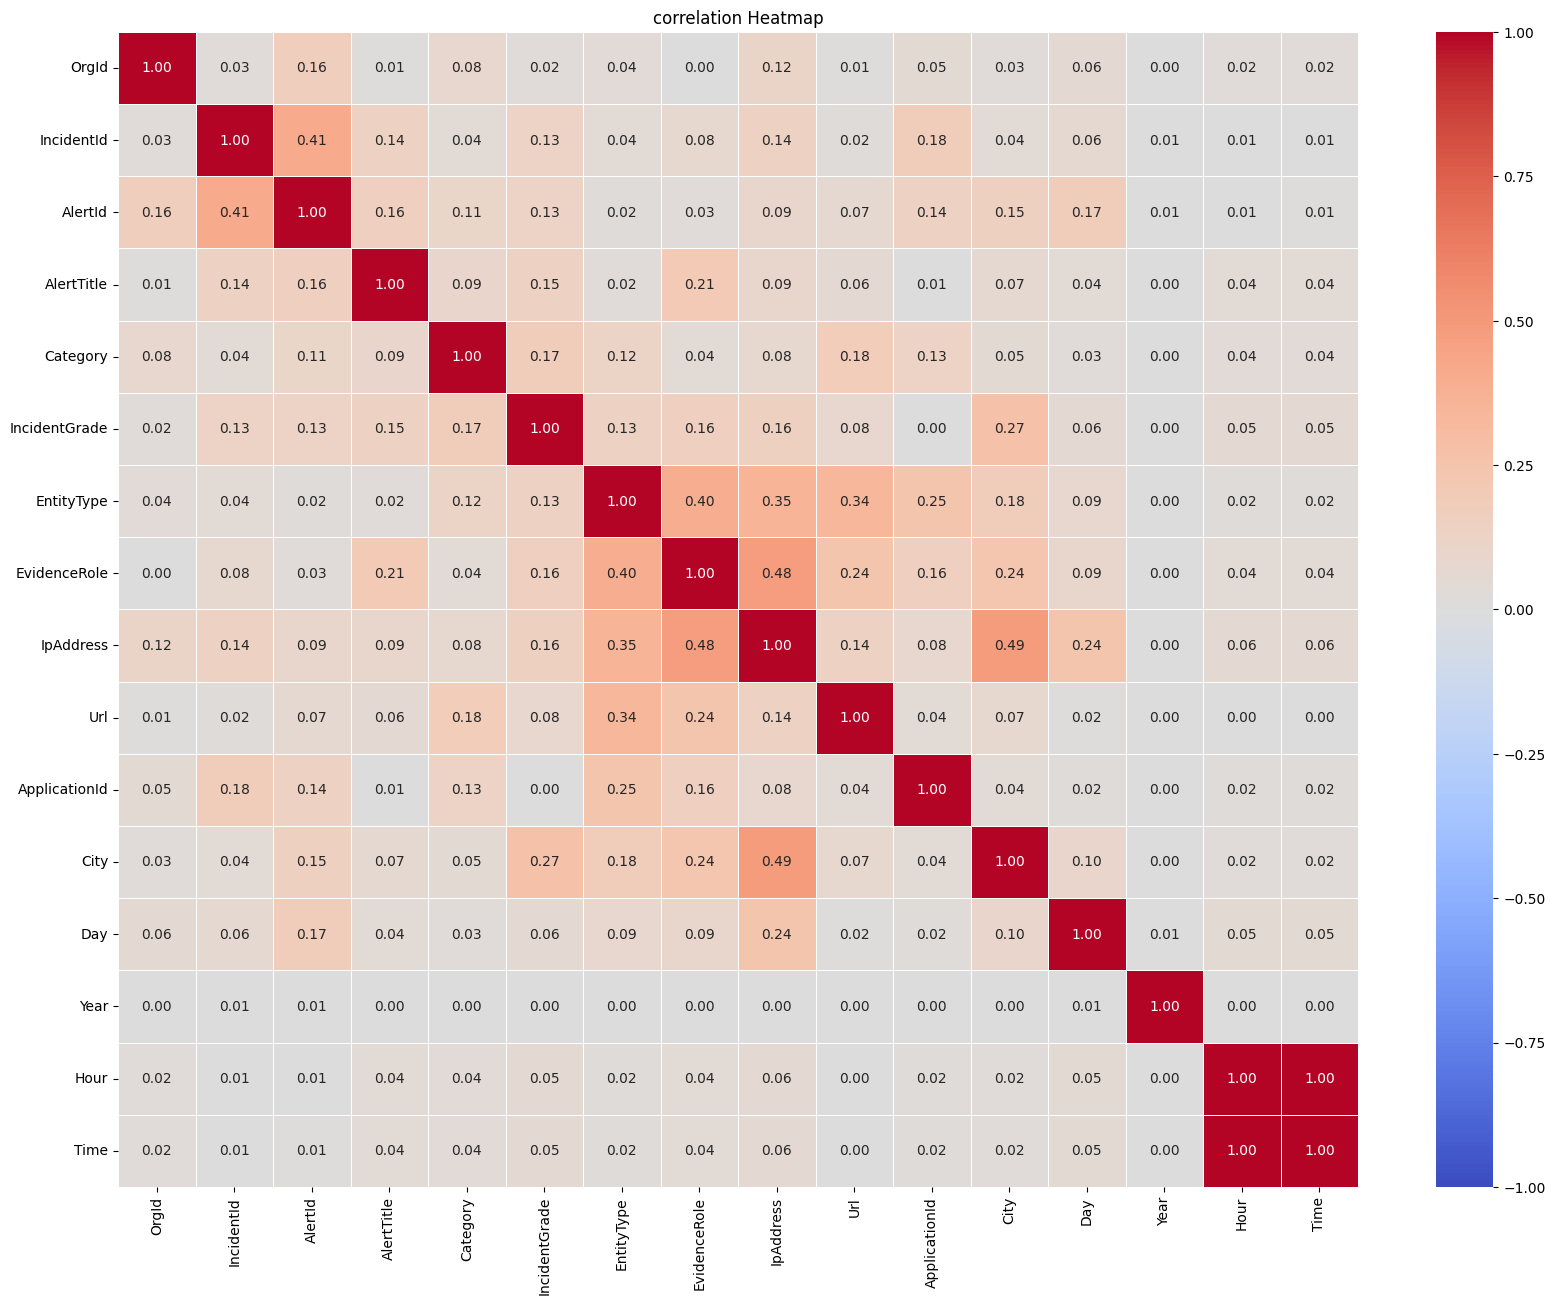

In [33]:
# selecting numerical col
numeric_df=train_data.select_dtypes(include=['number'])

corr_matrix= numeric_df.corr().abs()

# plot the heatmap
plt.figure(figsize=(20,15))
sns.heatmap(corr_matrix,annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, linewidths=0.5)
plt.title('correlation Heatmap')
plt.show()

In [3]:
# Check the structure of the processed data
print(train_data.head())

   OrgId  IncidentId  AlertId  AlertTitle  Category  IncidentGrade  \
0     26       18583   687462         813        12              0   
1     33        5065     3990          25         9              0   
2    201      150787   807590         444         6              0   
3    204      108287    28575        1233        16              2   
4     54      528202  1458226       58829         7              0   

   EntityType  EvidenceRole  IpAddress     Url  ApplicationId   City  Day  \
0           9             1     360606  160396           2251  10630    6   
1          17             0     360606  160396           2251  10630    3   
2          17             0     360606  160396           2251  10630   13   
3           9             1     360606  160396           2251  10630    8   
4           9             0     360606  160396           2251  10630    9   

   Year  Hour   Time  
0  2024     5  21407  
1  2024    10  38709  
2  2024     3  13000  
3  2024    16  60897  
4

In [10]:
def metrics(actual, predicted):
    acc = accuracy_score(actual, predicted) * 100
    prec = precision_score(actual, predicted, average="macro") * 100
    recall = recall_score(actual, predicted, average="macro") * 100
    macro_f1 = f1_score(actual, predicted, average="macro") * 100

    return pd.DataFrame({
        "Metrics": ["Accuracy", "Precision", "Recall", "Macro F1"],
        "Values": [acc, prec, recall, macro_f1]
    }).set_index("Metrics")

In [15]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV,RandomizedSearchCV
from sklearn.metrics import precision_score,f1_score,recall_score,classification_report,accuracy_score
import joblib
from tqdm import tqdm
os =RandomOverSampler(random_state = 94)
val =train_data.drop('IncidentGrade', axis =1)
tar = train_data['IncidentGrade']

# Train Test Split
traindata,testdata, trainlab,testlab = train_test_split(val,tar, test_size = 0.20, random_state = 43)
#oval,otar = os.fit_resample(val,tar)
#fs = RandomForestClassifier(n_estimators = 400, random_state =79)
#fs.fit(oval,otar)
# Assign class weights automatically to balance the classes
#rf = RandomForestClassifier(n_estimators=800, random_state=79, class_weight='balanced')
#rf.fit(val, tar)


In [16]:
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
import xgboost

In [17]:
xgbmodel = xgboost.XGBClassifier(n_estimators=200,learning_rate=0.1,random_state=100,n_jobs=-1,max_depth=8)

In [18]:
xgbmodel.fit(traindata,trainlab)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=-1,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [19]:
xgbtr_pred =xgbmodel.predict(traindata)
xgbts_pred =xgbmodel.predict(testdata)

In [20]:
xgbtrain_metrics = metrics(trainlab,xgbtr_pred)
xgbtest_metrics =metrics(testlab,xgbts_pred)

In [21]:
pd.DataFrame({
    "Training":xgbtrain_metrics["Values"],
    "Testing":xgbtest_metrics["Values"]
}).reset_index()

,Metrics,Training,Testing
0,Accuracy,92.864934,92.768713
1,Precision,93.395877,93.306606
2,Recall,91.731303,91.631606
3,Macro F1,92.463123,92.366601
